In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [36]:
# !dir "../csv"

RELATIVE_DIR = "../csv"
ROUND = 1

In [37]:
prices_df_byDay = {}
trades_df_byDay = {}

for day in [-2, -1, 0]:
    prices_df_byDay[day] = pd.read_csv(f"{RELATIVE_DIR}/prices_round_{ROUND}_day_{day}.csv", delimiter=";")
    trades_df_byDay[day] = pd.read_csv(f"{RELATIVE_DIR}/trades_round_{ROUND}_day_{day}_nn.csv", delimiter=";")

In [38]:
prices_df_byDay[-1].tail()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
19995,-1,999700,AMETHYSTS,9995,26,NaN,NaN,NaN,NaN,10005,26,NaN,NaN,NaN,NaN,10000.0,0.0
19996,-1,999800,STARFRUIT,5036,20,NaN,NaN,NaN,NaN,5043,20,NaN,NaN,NaN,NaN,5039.5,0.0
19997,-1,999800,AMETHYSTS,9995,20,NaN,NaN,NaN,NaN,10002,10,10005.0,20.0,NaN,NaN,9998.5,0.0
19998,-1,999900,AMETHYSTS,9996,2,9995.0,29.0,NaN,NaN,10004,2,10005.0,29.0,NaN,NaN,10000.0,0.0
19999,-1,999900,STARFRUIT,5036,31,NaN,NaN,NaN,NaN,5041,6,5043.0,31.0,NaN,NaN,5038.5,0.0


In [39]:
trades_df_byDay[-1].head()

,timestamp,buyer,seller,symbol,currency,price,quantity
0,0,NaN,NaN,STARFRUIT,SEASHELLS,5047.0,13
1,0,NaN,NaN,STARFRUIT,SEASHELLS,5047.0,1
2,0,NaN,NaN,AMETHYSTS,SEASHELLS,10004.0,1
3,1100,NaN,NaN,AMETHYSTS,SEASHELLS,9996.0,2
4,1700,NaN,NaN,AMETHYSTS,SEASHELLS,10002.0,1


In [40]:
rng = np.random.default_rng(1)

def plot_trade_matches(product, dev=0.1):
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.set_title(f"Match price of {product}")
    for day in [-2, -1, 0]:
        trades_df = trades_df_byDay[day][lambda df: df['symbol'] == product]
        numOfTrades = trades_df.shape[0]
        ax.scatter(trades_df['timestamp'], trades_df['price'] + rng.normal(0, dev, numOfTrades))
        
#         ax.set_xlim(500_000, 1_000_000)
    ax.plot(np.linspace(0, 1_000_000, 2), np.full(2, 5_000), linestyle='--', c='r')
    ax.plot(np.linspace(0, 1_000_000, 2), np.full(2, 5_050), linestyle='--', c='black')
    ax.legend(['day -2', 'day -1', 'day 0'])

In [41]:
# plot_trade_matches('AMETHYSTS', 0.1)

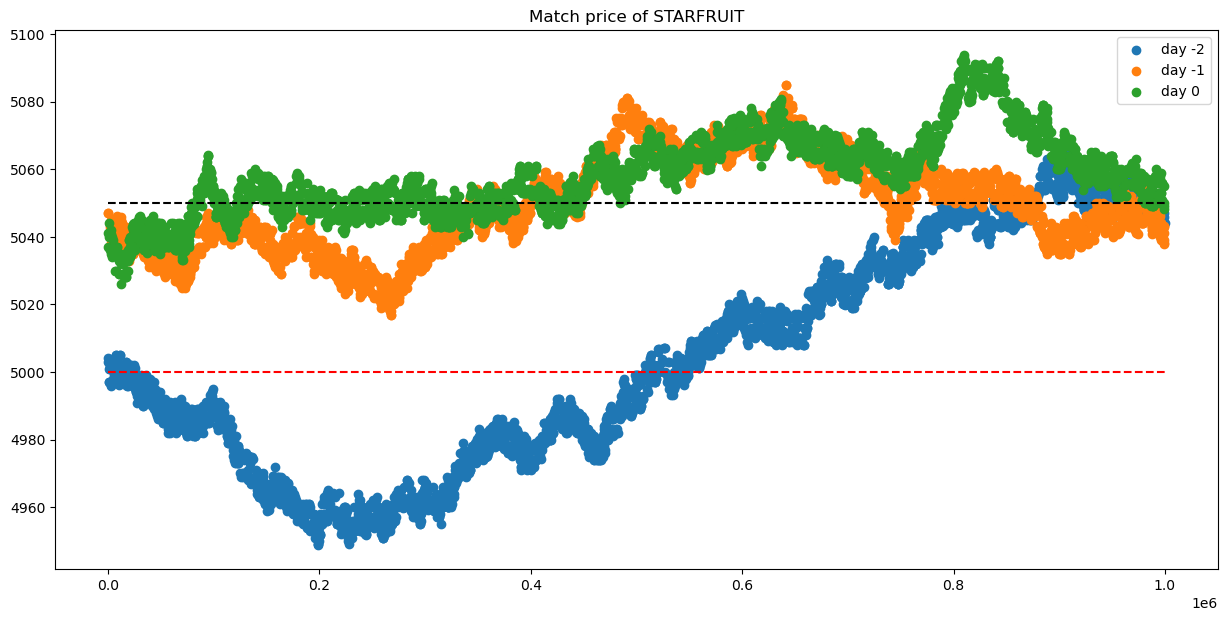

In [42]:
plot_trade_matches('STARFRUIT', 0.05)

In [43]:
# Buy when fair price is below 5_000 as it appears that the price will go up?

In [44]:
# Use past 100 timestamps as predictors for fair price in next timestamp
# Average the price if multiple trades occurred at same timestamp

In [45]:
p = 100 # number of predictors in linear regression

def getDesignResponseAndTimestamp(product, day):
    tradesAvg_df = trades_df_byDay[day][lambda df: df['symbol'] == product]
    tradesAvg_df = tradesAvg_df.groupby(['timestamp'], as_index=False).mean()
    
    n = tradesAvg_df.shape[0] - p # nunber of training observations
    
    X = [] # design matrix
    y = [] # response vector

    for i in range(n):
        X.append(tradesAvg_df.iloc[i:i+p]['price'].values)
        y.append(tradesAvg_df.iloc[i+p]['price'])

    X = np.array(X)
    y = np.array(y)
    
    return X, y, tradesAvg_df[p:]['timestamp']

In [46]:
X, y, timestamp = getDesignResponseAndTimestamp('STARFRUIT', -1)

print(f"{X.shape[0]} training observations")

C:\Users\joshu\AppData\Local\Temp\ipykernel_13244\2815931895.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tradesAvg_df = tradesAvg_df.groupby(['timestamp'], as_index=False).mean()


2488 training observations


In [47]:
lm_model = LinearRegression()
lm_model.fit(X, y)

LinearRegression()

In [48]:
lm_model.coef_, lm_model.intercept_

(array([-7.09233629e-03,  1.29177719e-02,  4.48012669e-03, -1.20731596e-02,
        -5.03707621e-02,  2.21852289e-02,  2.71842661e-02, -4.96096203e-03,
         1.84295596e-02, -3.11494385e-03, -3.77506114e-02,  4.47894756e-03,
        -2.90055640e-02,  1.04500629e-02, -1.33629658e-02, -9.42956646e-03,
         4.27848789e-02,  5.67636824e-02,  7.18796990e-03,  7.65927328e-03,
        -3.57437486e-02, -1.25401780e-02, -1.96256731e-02,  9.36118718e-03,
         2.87135060e-02,  9.44018802e-03, -1.62950592e-02,  1.29693167e-02,
        -5.02641644e-04,  3.49682635e-02, -5.05791797e-02, -2.47946644e-02,
        -1.29055155e-02,  1.25811615e-03,  1.55036254e-02,  3.36115509e-02,
        -4.64885530e-02,  2.97247047e-02, -1.76309930e-02,  3.16215215e-02,
        -2.23297728e-02,  2.33302006e-02, -2.57823340e-02,  2.35537849e-02,
        -1.19284097e-03, -2.92137145e-03, -5.91110105e-03,  9.82211146e-03,
        -5.67742012e-03, -1.00169970e-02, -1.30718218e-02, -1.67080144e-02,
         2.6

Residual mean = -4.616928490109358e-13, std = 3.001591155264128


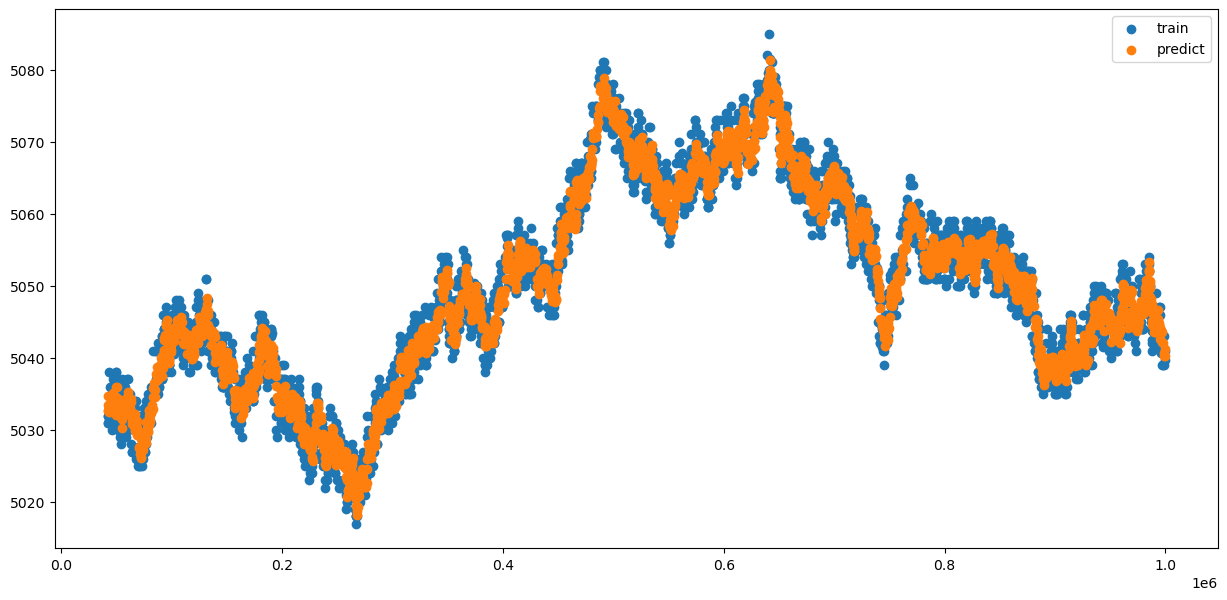

In [49]:
# Trained on STARFRUIT day -1

fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(timestamp, y)
ax.scatter(timestamp, lm_model.predict(X))
ax.legend(['train', 'predict'])
print(f"Residual mean = {np.mean(y - lm_model.predict(X))}, std = {np.std(y - lm_model.predict(X))}")

C:\Users\joshu\AppData\Local\Temp\ipykernel_13244\2815931895.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tradesAvg_df = tradesAvg_df.groupby(['timestamp'], as_index=False).mean()


Residual mean = -0.3066112778816386, std = 3.1208499492124115


(array([ 1.38690734e-02, -2.61422319e-02,  4.85844122e-03,  2.35013352e-02,
         2.79813870e-02, -5.93505775e-02,  1.05179720e-02,  2.21185248e-02,
        -1.57265639e-02,  3.15725092e-02, -1.11421003e-02,  1.13484613e-02,
         1.02088617e-02, -2.93607017e-02,  4.19198372e-03, -2.03987742e-02,
         2.56110861e-02, -3.33665589e-02,  1.24237467e-02, -1.05488954e-02,
        -2.58786330e-02,  1.67088016e-02, -1.11418029e-02,  1.07840495e-02,
         2.66525237e-02, -1.88799357e-04, -2.62499397e-02, -2.97388638e-02,
         9.25246124e-04,  1.00879161e-02, -1.00687970e-02,  3.45157919e-02,
         4.00093869e-02, -2.24057234e-02,  1.49014898e-02, -2.73513122e-02,
         3.07847616e-02, -4.18012407e-02,  1.73680244e-02, -1.71005597e-02,
         3.29131760e-02,  1.69024140e-02, -3.11553943e-02,  2.00917778e-02,
        -1.16147659e-03, -6.69516964e-03, -2.08328140e-02, -1.25189231e-02,
        -1.34687463e-02,  6.14237763e-04,  3.18041009e-02, -2.22603299e-02,
         3.9

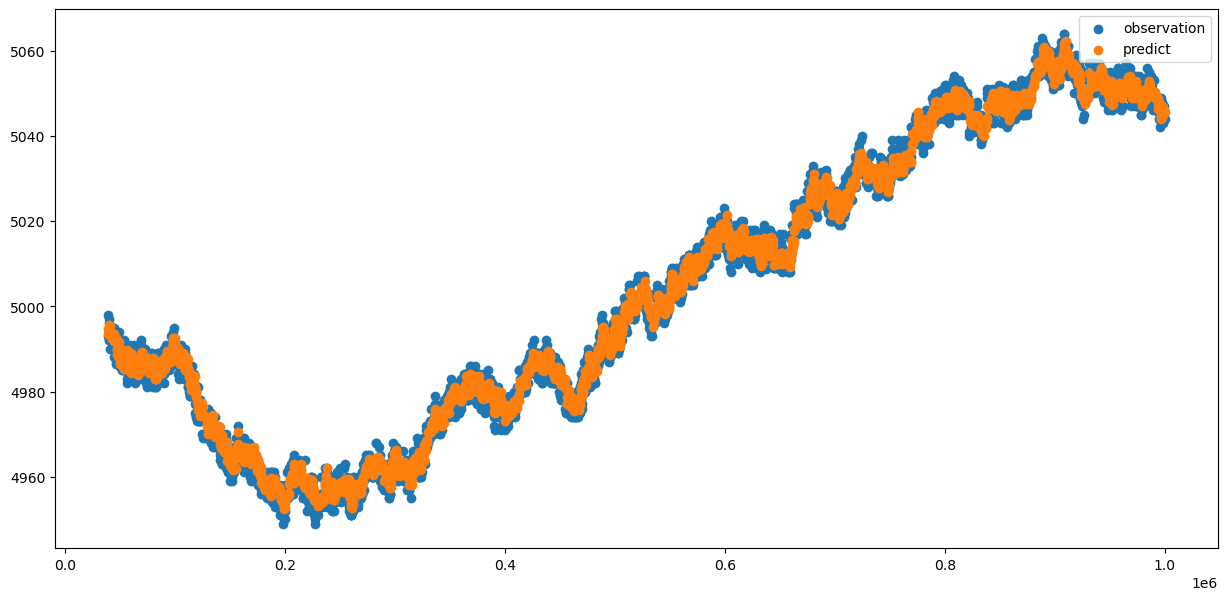

In [50]:
# Testing on STARFRUIT day -2

X, y, timestamp = getDesignResponseAndTimestamp('STARFRUIT', -2)
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(timestamp, y)
ax.scatter(timestamp, lm_model.predict(X))
ax.legend(['observation', 'predict'])
print(f"Residual mean = {np.mean(y - lm_model.predict(X))}, std = {np.std(y - lm_model.predict(X))}")

lm_model = LinearRegression()
lm_model.fit(X, y)

lm_model.coef_, lm_model.intercept_

C:\Users\joshu\AppData\Local\Temp\ipykernel_13244\2815931895.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tradesAvg_df = tradesAvg_df.groupby(['timestamp'], as_index=False).mean()


Residual mean = -0.04518052760840799, std = 3.1677025793589775


(array([-1.76890643e-02,  2.40470558e-02,  4.13206108e-02, -1.85113552e-02,
        -3.65451576e-02,  2.48685601e-02, -2.33753630e-02,  3.71227085e-02,
         2.74429461e-02, -3.73770056e-02, -3.30103227e-02,  9.68899179e-03,
        -1.72972223e-04,  1.23972606e-02, -9.56868364e-03,  1.54774586e-02,
         2.03358560e-02,  1.76446300e-02, -7.07106382e-03,  9.58773592e-03,
         4.90594290e-05, -5.68353920e-02, -1.21917788e-02, -7.71007738e-04,
        -2.55530432e-02,  1.51121364e-02,  2.78100376e-02,  2.19094801e-02,
         1.61203049e-02, -1.59218739e-02, -2.31867797e-02,  1.63667845e-02,
        -4.41069813e-02,  3.43490144e-02, -3.18710430e-02, -2.58192054e-02,
         4.61581553e-02,  6.19031139e-03,  4.58639468e-02, -1.28741033e-02,
        -1.59666284e-02, -3.92683529e-02,  3.33866164e-02,  1.23631481e-02,
        -2.46711658e-02, -1.14834414e-02, -1.42602975e-02,  3.34327625e-03,
         3.26724309e-02,  1.51697604e-02, -4.64900105e-02,  1.30787598e-02,
         1.4

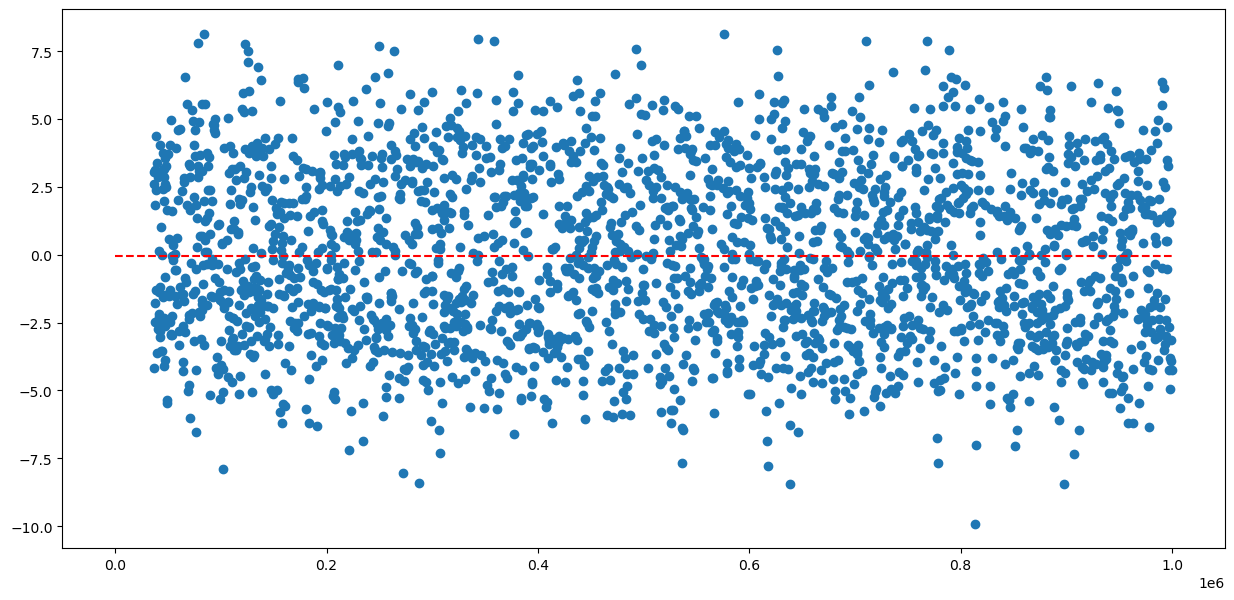

In [51]:
# Testing on STARFRUIT day 0

X, y, timestamp = getDesignResponseAndTimestamp('STARFRUIT', 0)
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(timestamp, y - lm_model.predict(X))
ax.plot(np.linspace(0, 1_000_000, 2), np.full(2, np.mean(y - lm_model.predict(X))), linestyle='--', c='r')
print(f"Residual mean = {np.mean(y - lm_model.predict(X))}, std = {np.std(y - lm_model.predict(X))}")

lm_model = LinearRegression()
lm_model.fit(X, y)

lm_model.coef_, lm_model.intercept_

### 